## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import tensorflow as tf

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# Regularizatioan
- Cost_Function = Loss + Cost_Function
- 經 regularizatioan, 可以使模型的 weights(權重)變 "更小" 
- ->> generalization

In [6]:
l1_ratio=1e-3
l1_ratio

0.001

In [45]:
from keras.regularizers import l1, l2, l1_l2
"""
建立神經網路，並加入 L1 或 L2
"""
# L1
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [46]:
# L2
def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [58]:
# L1_L2
def build_mlp_l1l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [62]:
"""Code Here
設定超參數
"""
LEARNING_RATE    = 1e-3
EPOCHS           = 100
BATCH_SIZE       = 512
MOMENTUM         = 0.95
L1_EXP           = [1e-1, 1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP           = [1e-1, 1e-2, 1e-4, 1e-8, 1e-12]
L1_L2_EXP        = [1e-1, 1e-2, 1e-4, 1e-8, 1e-12]

# L1

In [63]:
# L1
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [====================

50000/50000 [==============================] - 4s 77us/step - loss: 18.3353 - acc: 0.0972 - val_loss: 18.3000 - val_acc: 0.1000
Epoch 52/100
50000/50000 [==============================] - 4s 78us/step - loss: 18.3340 - acc: 0.0991 - val_loss: 18.1427 - val_acc: 0.1000
Epoch 53/100
50000/50000 [==============================] - 4s 78us/step - loss: 18.3358 - acc: 0.0981 - val_loss: 18.2031 - val_acc: 0.1000
Epoch 54/100
50000/50000 [==============================] - 4s 73us/step - loss: 18.3346 - acc: 0.0985 - val_loss: 18.1791 - val_acc: 0.1000
Epoch 55/100
50000/50000 [==============================] - 4s 74us/step - loss: 18.3362 - acc: 0.0980 - val_loss: 18.2782 - val_acc: 0.1000
Epoch 56/100
50000/50000 [==============================] - 4s 73us/step - loss: 18.3350 - acc: 0.0978 - val_loss: 18.2065 - val_acc: 0.1000
Epoch 57/100
50000/50000 [==============================] - 4s 73us/step - loss: 18.3339 - acc: 0.0990 - val_loss: 18.3679 - val_acc: 0.1000
Epoch 58/100
50000/50000 [

50000/50000 [==============================] - 4s 87us/step - loss: 299.5965 - acc: 0.2223 - val_loss: 177.7800 - val_acc: 0.2753
Epoch 2/100
50000/50000 [==============================] - 4s 74us/step - loss: 97.5948 - acc: 0.2703 - val_loss: 41.1440 - val_acc: 0.2639
Epoch 3/100
50000/50000 [==============================] - 4s 73us/step - loss: 26.4739 - acc: 0.1334 - val_loss: 17.2388 - val_acc: 0.1000
Epoch 4/100
50000/50000 [==============================] - 4s 73us/step - loss: 11.7848 - acc: 0.1000 - val_loss: 7.3114 - val_acc: 0.1000
Epoch 5/100
50000/50000 [==============================] - 4s 73us/step - loss: 5.1222 - acc: 0.1000 - val_loss: 3.7562 - val_acc: 0.1000
Epoch 6/100
50000/50000 [==============================] - 4s 73us/step - loss: 3.1221 - acc: 0.1000 - val_loss: 2.6520 - val_acc: 0.1000
Epoch 7/100
50000/50000 [==============================] - 4s 74us/step - loss: 2.5104 - acc: 0.0982 - val_loss: 2.4641 - val_acc: 0.1000
Epoch 8/100
50000/50000 [============

50000/50000 [==============================] - 4s 76us/step - loss: 2.4626 - acc: 0.0992 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 61/100
50000/50000 [==============================] - 4s 75us/step - loss: 2.4626 - acc: 0.0998 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 62/100
50000/50000 [==============================] - 4s 75us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 63/100
50000/50000 [==============================] - 4s 76us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 64/100
50000/50000 [==============================] - 4s 74us/step - loss: 2.4626 - acc: 0.0989 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 65/100
50000/50000 [==============================] - 4s 74us/step - loss: 2.4626 - acc: 0.0997 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 66/100
50000/50000 [==============================] - 4s 74us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 67/100
50000/50000 [==============

50000/50000 [==============================] - 4s 75us/step - loss: 5.2632 - acc: 0.4453 - val_loss: 5.2443 - val_acc: 0.4429
Epoch 12/100
50000/50000 [==============================] - 4s 75us/step - loss: 5.2135 - acc: 0.4523 - val_loss: 5.1999 - val_acc: 0.4415
Epoch 13/100
50000/50000 [==============================] - 4s 76us/step - loss: 5.1644 - acc: 0.4568 - val_loss: 5.1530 - val_acc: 0.4550
Epoch 14/100
50000/50000 [==============================] - 4s 74us/step - loss: 5.1190 - acc: 0.4631 - val_loss: 5.1090 - val_acc: 0.4535
Epoch 15/100
50000/50000 [==============================] - 4s 74us/step - loss: 5.0721 - acc: 0.4673 - val_loss: 5.0697 - val_acc: 0.4592
Epoch 16/100
50000/50000 [==============================] - 4s 74us/step - loss: 5.0272 - acc: 0.4731 - val_loss: 5.0268 - val_acc: 0.4613
Epoch 17/100
50000/50000 [==============================] - 4s 74us/step - loss: 4.9817 - acc: 0.4791 - val_loss: 4.9853 - val_acc: 0.4667
Epoch 18/100
50000/50000 [==============

50000/50000 [==============================] - 4s 74us/step - loss: 3.2033 - acc: 0.6224 - val_loss: 3.4280 - val_acc: 0.5374
Epoch 71/100
50000/50000 [==============================] - 4s 73us/step - loss: 3.1730 - acc: 0.6265 - val_loss: 3.4069 - val_acc: 0.5403
Epoch 72/100
50000/50000 [==============================] - 4s 76us/step - loss: 3.1549 - acc: 0.6262 - val_loss: 3.3730 - val_acc: 0.5425
Epoch 73/100
50000/50000 [==============================] - 4s 73us/step - loss: 3.1218 - acc: 0.6295 - val_loss: 3.4197 - val_acc: 0.5174
Epoch 74/100
50000/50000 [==============================] - 4s 73us/step - loss: 3.0984 - acc: 0.6315 - val_loss: 3.3783 - val_acc: 0.5301
Epoch 75/100
50000/50000 [==============================] - 4s 74us/step - loss: 3.0674 - acc: 0.6345 - val_loss: 3.3269 - val_acc: 0.5407
Epoch 76/100
50000/50000 [==============================] - 4s 73us/step - loss: 3.0523 - acc: 0.6333 - val_loss: 3.3274 - val_acc: 0.5324
Epoch 77/100
50000/50000 [==============

50000/50000 [==============================] - 4s 76us/step - loss: 1.4230 - acc: 0.5050 - val_loss: 1.4609 - val_acc: 0.4847
Epoch 22/100
50000/50000 [==============================] - 4s 77us/step - loss: 1.4110 - acc: 0.5079 - val_loss: 1.4538 - val_acc: 0.4858
Epoch 23/100
50000/50000 [==============================] - 4s 74us/step - loss: 1.3985 - acc: 0.5122 - val_loss: 1.4481 - val_acc: 0.4884
Epoch 24/100
50000/50000 [==============================] - 4s 73us/step - loss: 1.3868 - acc: 0.5161 - val_loss: 1.4356 - val_acc: 0.4885
Epoch 25/100
50000/50000 [==============================] - 4s 74us/step - loss: 1.3733 - acc: 0.5210 - val_loss: 1.4279 - val_acc: 0.4957
Epoch 26/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.3625 - acc: 0.5250 - val_loss: 1.4239 - val_acc: 0.4950
Epoch 27/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.3520 - acc: 0.5259 - val_loss: 1.4190 - val_acc: 0.5003
Epoch 28/100
50000/50000 [==============

50000/50000 [==============================] - 4s 75us/step - loss: 0.8992 - acc: 0.6867 - val_loss: 1.4605 - val_acc: 0.5062
Epoch 81/100
50000/50000 [==============================] - 4s 75us/step - loss: 0.8967 - acc: 0.6863 - val_loss: 1.4056 - val_acc: 0.5305
Epoch 82/100
50000/50000 [==============================] - 4s 74us/step - loss: 0.8780 - acc: 0.6952 - val_loss: 1.3573 - val_acc: 0.5417
Epoch 83/100
50000/50000 [==============================] - 4s 75us/step - loss: 0.8762 - acc: 0.6965 - val_loss: 1.4384 - val_acc: 0.5175
Epoch 84/100
50000/50000 [==============================] - 4s 77us/step - loss: 0.8682 - acc: 0.6967 - val_loss: 1.4546 - val_acc: 0.5145
Epoch 85/100
50000/50000 [==============================] - 4s 77us/step - loss: 0.8677 - acc: 0.6966 - val_loss: 1.3527 - val_acc: 0.5410
Epoch 86/100
50000/50000 [==============================] - 4s 76us/step - loss: 0.8474 - acc: 0.7045 - val_loss: 1.4083 - val_acc: 0.5255
Epoch 87/100
50000/50000 [==============

50000/50000 [==============================] - 4s 80us/step - loss: 1.3027 - acc: 0.5468 - val_loss: 1.3928 - val_acc: 0.5104
Epoch 32/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.2912 - acc: 0.5503 - val_loss: 1.3912 - val_acc: 0.5084
Epoch 33/100
50000/50000 [==============================] - 4s 79us/step - loss: 1.2815 - acc: 0.5536 - val_loss: 1.3958 - val_acc: 0.5091
Epoch 34/100
50000/50000 [==============================] - 4s 79us/step - loss: 1.2720 - acc: 0.5568 - val_loss: 1.3840 - val_acc: 0.5076
Epoch 35/100
50000/50000 [==============================] - 4s 80us/step - loss: 1.2608 - acc: 0.5595 - val_loss: 1.3977 - val_acc: 0.5033
Epoch 36/100
50000/50000 [==============================] - 4s 80us/step - loss: 1.2535 - acc: 0.5631 - val_loss: 1.3808 - val_acc: 0.5168
Epoch 37/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.2433 - acc: 0.5655 - val_loss: 1.3634 - val_acc: 0.5179
Epoch 38/100
50000/50000 [==============

50000/50000 [==============================] - 4s 73us/step - loss: 0.8243 - acc: 0.7164 - val_loss: 1.4006 - val_acc: 0.5413
Epoch 91/100
50000/50000 [==============================] - 4s 73us/step - loss: 0.8132 - acc: 0.7181 - val_loss: 1.4297 - val_acc: 0.5356
Epoch 92/100
50000/50000 [==============================] - 4s 73us/step - loss: 0.8127 - acc: 0.7175 - val_loss: 1.4307 - val_acc: 0.5374
Epoch 93/100
50000/50000 [==============================] - 4s 74us/step - loss: 0.8034 - acc: 0.7227 - val_loss: 1.4103 - val_acc: 0.5394
Epoch 94/100
50000/50000 [==============================] - 4s 73us/step - loss: 0.7911 - acc: 0.7254 - val_loss: 1.4124 - val_acc: 0.5356
Epoch 95/100
50000/50000 [==============================] - 4s 79us/step - loss: 0.7776 - acc: 0.7305 - val_loss: 1.3813 - val_acc: 0.5454
Epoch 96/100
50000/50000 [==============================] - 4s 76us/step - loss: 0.7881 - acc: 0.7287 - val_loss: 1.4660 - val_acc: 0.5296
Epoch 97/100
50000/50000 [==============

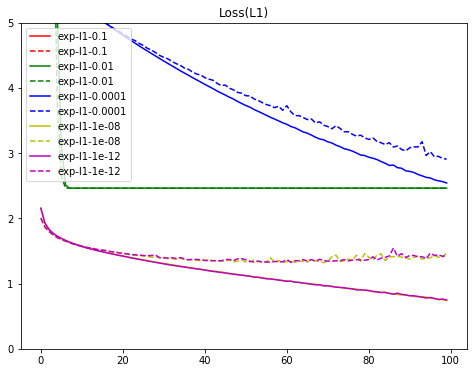

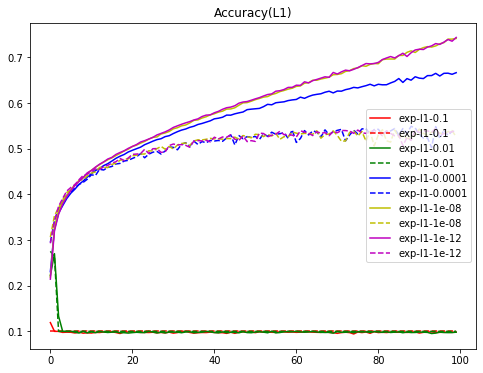

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss(L1)")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy(L1)")
plt.legend()
plt.show()

# L2 

In [65]:
# L2
results = {}
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [====================

50000/50000 [==============================] - 4s 74us/step - loss: 2.1669 - acc: 0.1906 - val_loss: 2.1653 - val_acc: 0.1953
Epoch 53/100
50000/50000 [==============================] - 4s 73us/step - loss: 2.1664 - acc: 0.1934 - val_loss: 2.1648 - val_acc: 0.1950
Epoch 54/100
50000/50000 [==============================] - 4s 72us/step - loss: 2.1658 - acc: 0.1918 - val_loss: 2.1642 - val_acc: 0.1963
Epoch 55/100
50000/50000 [==============================] - 4s 73us/step - loss: 2.1653 - acc: 0.1938 - val_loss: 2.1637 - val_acc: 0.1943
Epoch 56/100
50000/50000 [==============================] - 4s 72us/step - loss: 2.1648 - acc: 0.1908 - val_loss: 2.1637 - val_acc: 0.1919
Epoch 57/100
50000/50000 [==============================] - 4s 73us/step - loss: 2.1643 - acc: 0.1908 - val_loss: 2.1631 - val_acc: 0.1951
Epoch 58/100
50000/50000 [==============================] - 4s 73us/step - loss: 2.1636 - acc: 0.1923 - val_loss: 2.1630 - val_acc: 0.1910
Epoch 59/100
50000/50000 [==============

50000/50000 [==============================] - 4s 73us/step - loss: 13.4773 - acc: 0.3465 - val_loss: 13.0017 - val_acc: 0.3591
Epoch 4/100
50000/50000 [==============================] - 4s 73us/step - loss: 12.5610 - acc: 0.3645 - val_loss: 12.1292 - val_acc: 0.3747
Epoch 5/100
50000/50000 [==============================] - 4s 73us/step - loss: 11.7270 - acc: 0.3763 - val_loss: 11.3287 - val_acc: 0.3800
Epoch 6/100
50000/50000 [==============================] - 4s 73us/step - loss: 10.9602 - acc: 0.3865 - val_loss: 10.5984 - val_acc: 0.3875
Epoch 7/100
50000/50000 [==============================] - 4s 73us/step - loss: 10.2550 - acc: 0.3930 - val_loss: 9.9212 - val_acc: 0.3947
Epoch 8/100
50000/50000 [==============================] - 4s 72us/step - loss: 9.6055 - acc: 0.3995 - val_loss: 9.2952 - val_acc: 0.4036
Epoch 9/100
50000/50000 [==============================] - 4s 75us/step - loss: 9.0049 - acc: 0.4054 - val_loss: 8.7234 - val_acc: 0.4037
Epoch 10/100
50000/50000 [===========

50000/50000 [==============================] - 4s 75us/step - loss: 1.7496 - acc: 0.5058 - val_loss: 1.7999 - val_acc: 0.4881
Epoch 63/100
50000/50000 [==============================] - 4s 74us/step - loss: 1.7390 - acc: 0.5094 - val_loss: 1.7750 - val_acc: 0.4911
Epoch 64/100
50000/50000 [==============================] - 4s 73us/step - loss: 1.7296 - acc: 0.5102 - val_loss: 1.7739 - val_acc: 0.4900
Epoch 65/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.7206 - acc: 0.5085 - val_loss: 1.7627 - val_acc: 0.4897
Epoch 66/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.7111 - acc: 0.5097 - val_loss: 1.7606 - val_acc: 0.4838
Epoch 67/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.7039 - acc: 0.5120 - val_loss: 1.7493 - val_acc: 0.4980
Epoch 68/100
50000/50000 [==============================] - 4s 73us/step - loss: 1.6964 - acc: 0.5143 - val_loss: 1.7399 - val_acc: 0.4927
Epoch 69/100
50000/50000 [==============

50000/50000 [==============================] - 4s 75us/step - loss: 1.6735 - acc: 0.4627 - val_loss: 1.6826 - val_acc: 0.4544
Epoch 14/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.6572 - acc: 0.4690 - val_loss: 1.6729 - val_acc: 0.4617
Epoch 15/100
50000/50000 [==============================] - 4s 77us/step - loss: 1.6419 - acc: 0.4733 - val_loss: 1.6583 - val_acc: 0.4628
Epoch 16/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.6258 - acc: 0.4802 - val_loss: 1.6460 - val_acc: 0.4658
Epoch 17/100
50000/50000 [==============================] - 4s 73us/step - loss: 1.6130 - acc: 0.4847 - val_loss: 1.6440 - val_acc: 0.4692
Epoch 18/100
50000/50000 [==============================] - 4s 74us/step - loss: 1.5993 - acc: 0.4882 - val_loss: 1.6254 - val_acc: 0.4737
Epoch 19/100
50000/50000 [==============================] - 4s 73us/step - loss: 1.5852 - acc: 0.4947 - val_loss: 1.6267 - val_acc: 0.4699
Epoch 20/100
50000/50000 [==============

50000/50000 [==============================] - 4s 73us/step - loss: 1.1020 - acc: 0.6649 - val_loss: 1.5230 - val_acc: 0.5190
Epoch 73/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.1044 - acc: 0.6641 - val_loss: 1.4806 - val_acc: 0.5326
Epoch 74/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.0848 - acc: 0.6710 - val_loss: 1.4729 - val_acc: 0.5355
Epoch 75/100
50000/50000 [==============================] - 4s 86us/step - loss: 1.0719 - acc: 0.6767 - val_loss: 1.4810 - val_acc: 0.5339
Epoch 76/100
50000/50000 [==============================] - 4s 82us/step - loss: 1.0752 - acc: 0.6726 - val_loss: 1.5248 - val_acc: 0.5277
Epoch 77/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.0666 - acc: 0.6775 - val_loss: 1.4730 - val_acc: 0.5391
Epoch 78/100
50000/50000 [==============================] - 4s 73us/step - loss: 1.0577 - acc: 0.6812 - val_loss: 1.4918 - val_acc: 0.5328
Epoch 79/100
50000/50000 [==============

50000/50000 [==============================] - 4s 73us/step - loss: 1.3916 - acc: 0.5134 - val_loss: 1.4415 - val_acc: 0.4887
Epoch 24/100
50000/50000 [==============================] - 4s 72us/step - loss: 1.3786 - acc: 0.5177 - val_loss: 1.4355 - val_acc: 0.4889
Epoch 25/100
50000/50000 [==============================] - 4s 72us/step - loss: 1.3676 - acc: 0.5219 - val_loss: 1.4265 - val_acc: 0.4935
Epoch 26/100
50000/50000 [==============================] - 4s 72us/step - loss: 1.3556 - acc: 0.5262 - val_loss: 1.4304 - val_acc: 0.4925
Epoch 27/100
50000/50000 [==============================] - 4s 72us/step - loss: 1.3438 - acc: 0.5293 - val_loss: 1.4191 - val_acc: 0.4956
Epoch 28/100
50000/50000 [==============================] - 4s 73us/step - loss: 1.3321 - acc: 0.5342 - val_loss: 1.4092 - val_acc: 0.4981
Epoch 29/100
50000/50000 [==============================] - 4s 73us/step - loss: 1.3218 - acc: 0.5370 - val_loss: 1.4033 - val_acc: 0.4995
Epoch 30/100
50000/50000 [==============

50000/50000 [==============================] - 4s 72us/step - loss: 0.8736 - acc: 0.6986 - val_loss: 1.5406 - val_acc: 0.4987
Epoch 83/100
50000/50000 [==============================] - 4s 72us/step - loss: 0.8668 - acc: 0.7005 - val_loss: 1.3873 - val_acc: 0.5305
Epoch 84/100
50000/50000 [==============================] - 4s 73us/step - loss: 0.8538 - acc: 0.7029 - val_loss: 1.3644 - val_acc: 0.5318
Epoch 85/100
50000/50000 [==============================] - 4s 74us/step - loss: 0.8519 - acc: 0.7036 - val_loss: 1.4003 - val_acc: 0.5257
Epoch 86/100
50000/50000 [==============================] - 4s 76us/step - loss: 0.8384 - acc: 0.7091 - val_loss: 1.4277 - val_acc: 0.5205
Epoch 87/100
50000/50000 [==============================] - 4s 73us/step - loss: 0.8327 - acc: 0.7132 - val_loss: 1.3848 - val_acc: 0.5282
Epoch 88/100
50000/50000 [==============================] - 4s 74us/step - loss: 0.8255 - acc: 0.7140 - val_loss: 1.3841 - val_acc: 0.5321
Epoch 89/100
50000/50000 [==============

50000/50000 [==============================] - 4s 75us/step - loss: 1.2834 - acc: 0.5509 - val_loss: 1.3794 - val_acc: 0.5045
Epoch 34/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.2747 - acc: 0.5523 - val_loss: 1.3803 - val_acc: 0.5054
Epoch 35/100
50000/50000 [==============================] - 4s 73us/step - loss: 1.2642 - acc: 0.5568 - val_loss: 1.3724 - val_acc: 0.5100
Epoch 36/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.2550 - acc: 0.5603 - val_loss: 1.3754 - val_acc: 0.5064
Epoch 37/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.2453 - acc: 0.5639 - val_loss: 1.3627 - val_acc: 0.5142
Epoch 38/100
50000/50000 [==============================] - 4s 79us/step - loss: 1.2342 - acc: 0.5651 - val_loss: 1.3653 - val_acc: 0.5145
Epoch 39/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.2254 - acc: 0.5697 - val_loss: 1.3607 - val_acc: 0.5134
Epoch 40/100
50000/50000 [==============

50000/50000 [==============================] - 4s 75us/step - loss: 0.8243 - acc: 0.7144 - val_loss: 1.3923 - val_acc: 0.5348
Epoch 93/100
50000/50000 [==============================] - 4s 76us/step - loss: 0.8222 - acc: 0.7132 - val_loss: 1.4852 - val_acc: 0.5113
Epoch 94/100
50000/50000 [==============================] - 4s 76us/step - loss: 0.8124 - acc: 0.7185 - val_loss: 1.3865 - val_acc: 0.5388
Epoch 95/100
50000/50000 [==============================] - 4s 76us/step - loss: 0.8035 - acc: 0.7203 - val_loss: 1.3853 - val_acc: 0.5395
Epoch 96/100
50000/50000 [==============================] - 4s 73us/step - loss: 0.7944 - acc: 0.7252 - val_loss: 1.3888 - val_acc: 0.5376
Epoch 97/100
50000/50000 [==============================] - 4s 73us/step - loss: 0.8042 - acc: 0.7211 - val_loss: 1.4208 - val_acc: 0.5314
Epoch 98/100
50000/50000 [==============================] - 4s 74us/step - loss: 0.7872 - acc: 0.7260 - val_loss: 1.3841 - val_acc: 0.5444
Epoch 99/100
50000/50000 [==============

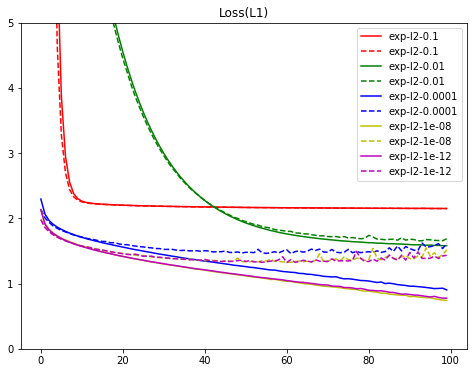

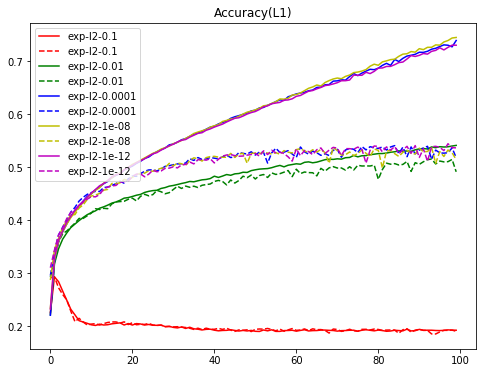

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss(L1)")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy(L1)")
plt.legend()
plt.show()

#  L1_l2

In [67]:
# L1_L2
results = {}
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1l2(input_shape=x_train.shape[1:], l1l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [====================

50000/50000 [==============================] - 4s 81us/step - loss: 18.2738 - acc: 0.0987 - val_loss: 18.2561 - val_acc: 0.1000
Epoch 52/100
50000/50000 [==============================] - 4s 81us/step - loss: 18.2718 - acc: 0.0981 - val_loss: 18.1429 - val_acc: 0.1000
Epoch 53/100
50000/50000 [==============================] - 4s 83us/step - loss: 18.2706 - acc: 0.0970 - val_loss: 18.1813 - val_acc: 0.1000
Epoch 54/100
50000/50000 [==============================] - 4s 83us/step - loss: 18.2716 - acc: 0.0969 - val_loss: 18.1818 - val_acc: 0.1000
Epoch 55/100
50000/50000 [==============================] - 4s 80us/step - loss: 18.2700 - acc: 0.0987 - val_loss: 18.1772 - val_acc: 0.1000
Epoch 56/100
50000/50000 [==============================] - 4s 80us/step - loss: 18.2681 - acc: 0.0981 - val_loss: 18.1830 - val_acc: 0.1000
Epoch 57/100
50000/50000 [==============================] - 4s 79us/step - loss: 18.2664 - acc: 0.1000 - val_loss: 18.3145 - val_acc: 0.1000
Epoch 58/100
50000/50000 [

50000/50000 [==============================] - 5s 93us/step - loss: 304.2666 - acc: 0.2213 - val_loss: 173.2452 - val_acc: 0.2695
Epoch 2/100
50000/50000 [==============================] - 4s 80us/step - loss: 90.9372 - acc: 0.2654 - val_loss: 35.8951 - val_acc: 0.2550
Epoch 3/100
50000/50000 [==============================] - 4s 80us/step - loss: 22.8789 - acc: 0.1179 - val_loss: 13.8939 - val_acc: 0.1000
Epoch 4/100
50000/50000 [==============================] - 4s 79us/step - loss: 8.8786 - acc: 0.1000 - val_loss: 5.1511 - val_acc: 0.1000
Epoch 5/100
50000/50000 [==============================] - 4s 78us/step - loss: 3.8261 - acc: 0.0998 - val_loss: 2.9548 - val_acc: 0.1000
Epoch 6/100
50000/50000 [==============================] - 4s 78us/step - loss: 2.6184 - acc: 0.0989 - val_loss: 2.4716 - val_acc: 0.1000
Epoch 7/100
50000/50000 [==============================] - 4s 78us/step - loss: 2.4638 - acc: 0.1000 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 8/100
50000/50000 [=============

50000/50000 [==============================] - 4s 78us/step - loss: 2.4618 - acc: 0.0988 - val_loss: 2.4617 - val_acc: 0.1000
Epoch 61/100
50000/50000 [==============================] - 4s 78us/step - loss: 2.4618 - acc: 0.0958 - val_loss: 2.4617 - val_acc: 0.1000
Epoch 62/100
50000/50000 [==============================] - 4s 78us/step - loss: 2.4618 - acc: 0.0971 - val_loss: 2.4617 - val_acc: 0.1000
Epoch 63/100
50000/50000 [==============================] - 4s 79us/step - loss: 2.4617 - acc: 0.0993 - val_loss: 2.4617 - val_acc: 0.1000
Epoch 64/100
50000/50000 [==============================] - 4s 81us/step - loss: 2.4617 - acc: 0.0972 - val_loss: 2.4616 - val_acc: 0.1000
Epoch 65/100
50000/50000 [==============================] - 4s 79us/step - loss: 2.4617 - acc: 0.0980 - val_loss: 2.4617 - val_acc: 0.1000
Epoch 66/100
50000/50000 [==============================] - 4s 80us/step - loss: 2.4617 - acc: 0.0955 - val_loss: 2.4617 - val_acc: 0.1000
Epoch 67/100
50000/50000 [==============

50000/50000 [==============================] - 4s 87us/step - loss: 9.5072 - acc: 0.4119 - val_loss: 9.1867 - val_acc: 0.4106
Epoch 12/100
50000/50000 [==============================] - 4s 85us/step - loss: 8.8915 - acc: 0.4145 - val_loss: 8.5961 - val_acc: 0.4154
Epoch 13/100
50000/50000 [==============================] - 4s 85us/step - loss: 8.3229 - acc: 0.4176 - val_loss: 8.0508 - val_acc: 0.4200
Epoch 14/100
50000/50000 [==============================] - 4s 84us/step - loss: 7.7976 - acc: 0.4214 - val_loss: 7.5459 - val_acc: 0.4257
Epoch 15/100
50000/50000 [==============================] - 4s 84us/step - loss: 7.3140 - acc: 0.4229 - val_loss: 7.0831 - val_acc: 0.4233
Epoch 16/100
50000/50000 [==============================] - 4s 78us/step - loss: 6.8659 - acc: 0.4251 - val_loss: 6.6526 - val_acc: 0.4261
Epoch 17/100
50000/50000 [==============================] - 4s 78us/step - loss: 6.4540 - acc: 0.4274 - val_loss: 6.2583 - val_acc: 0.4269
Epoch 18/100
50000/50000 [==============

50000/50000 [==============================] - 4s 81us/step - loss: 1.8070 - acc: 0.4775 - val_loss: 1.8210 - val_acc: 0.4740
Epoch 71/100
50000/50000 [==============================] - 4s 87us/step - loss: 1.8023 - acc: 0.4756 - val_loss: 1.8185 - val_acc: 0.4751
Epoch 72/100
50000/50000 [==============================] - 4s 84us/step - loss: 1.7991 - acc: 0.4756 - val_loss: 1.8143 - val_acc: 0.4729
Epoch 73/100
50000/50000 [==============================] - 4s 84us/step - loss: 1.7937 - acc: 0.4774 - val_loss: 1.8120 - val_acc: 0.4688
Epoch 74/100
50000/50000 [==============================] - 4s 85us/step - loss: 1.7907 - acc: 0.4791 - val_loss: 1.8053 - val_acc: 0.4730
Epoch 75/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.7858 - acc: 0.4792 - val_loss: 1.8059 - val_acc: 0.4736
Epoch 76/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.7813 - acc: 0.4801 - val_loss: 1.8083 - val_acc: 0.4746
Epoch 77/100
50000/50000 [==============

50000/50000 [==============================] - 4s 78us/step - loss: 4.5484 - acc: 0.4433 - val_loss: 4.4419 - val_acc: 0.4422
Epoch 22/100
50000/50000 [==============================] - 4s 78us/step - loss: 4.3339 - acc: 0.4461 - val_loss: 4.2381 - val_acc: 0.4468
Epoch 23/100
50000/50000 [==============================] - 4s 78us/step - loss: 4.1350 - acc: 0.4464 - val_loss: 4.0461 - val_acc: 0.4430
Epoch 24/100
50000/50000 [==============================] - 4s 78us/step - loss: 3.9507 - acc: 0.4495 - val_loss: 3.8717 - val_acc: 0.4419
Epoch 25/100
50000/50000 [==============================] - 4s 78us/step - loss: 3.7811 - acc: 0.4530 - val_loss: 3.7074 - val_acc: 0.4493
Epoch 26/100
50000/50000 [==============================] - 4s 80us/step - loss: 3.6236 - acc: 0.4546 - val_loss: 3.5561 - val_acc: 0.4542
Epoch 27/100
50000/50000 [==============================] - 4s 82us/step - loss: 3.4774 - acc: 0.4558 - val_loss: 3.4183 - val_acc: 0.4519
Epoch 28/100
50000/50000 [==============

50000/50000 [==============================] - 4s 79us/step - loss: 1.6341 - acc: 0.5255 - val_loss: 1.7572 - val_acc: 0.4748
Epoch 81/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.6298 - acc: 0.5259 - val_loss: 1.6960 - val_acc: 0.4964
Epoch 82/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.6263 - acc: 0.5283 - val_loss: 1.6867 - val_acc: 0.5050
Epoch 83/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.6236 - acc: 0.5263 - val_loss: 1.6868 - val_acc: 0.5035
Epoch 84/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.6173 - acc: 0.5303 - val_loss: 1.6798 - val_acc: 0.5055
Epoch 85/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.6194 - acc: 0.5271 - val_loss: 1.6754 - val_acc: 0.5084
Epoch 86/100
50000/50000 [==============================] - 4s 79us/step - loss: 1.6115 - acc: 0.5308 - val_loss: 1.6748 - val_acc: 0.5097
Epoch 87/100
50000/50000 [==============

50000/50000 [==============================] - 4s 79us/step - loss: 2.9863 - acc: 0.4680 - val_loss: 2.9541 - val_acc: 0.4625
Epoch 32/100
50000/50000 [==============================] - 4s 89us/step - loss: 2.8868 - acc: 0.4720 - val_loss: 2.8530 - val_acc: 0.4628
Epoch 33/100
50000/50000 [==============================] - 4s 88us/step - loss: 2.7947 - acc: 0.4729 - val_loss: 2.7637 - val_acc: 0.4697
Epoch 34/100
50000/50000 [==============================] - 4s 84us/step - loss: 2.7086 - acc: 0.4747 - val_loss: 2.6858 - val_acc: 0.4674
Epoch 35/100
50000/50000 [==============================] - 4s 85us/step - loss: 2.6303 - acc: 0.4767 - val_loss: 2.6098 - val_acc: 0.4684
Epoch 36/100
50000/50000 [==============================] - 4s 86us/step - loss: 2.5575 - acc: 0.4776 - val_loss: 2.5393 - val_acc: 0.4685
Epoch 37/100
50000/50000 [==============================] - 4s 86us/step - loss: 2.4905 - acc: 0.4794 - val_loss: 2.4742 - val_acc: 0.4743
Epoch 38/100
50000/50000 [==============

50000/50000 [==============================] - 4s 78us/step - loss: 1.5981 - acc: 0.5356 - val_loss: 1.6864 - val_acc: 0.4916
Epoch 91/100
50000/50000 [==============================] - 4s 86us/step - loss: 1.5962 - acc: 0.5367 - val_loss: 1.6647 - val_acc: 0.5157
Epoch 92/100
50000/50000 [==============================] - 4s 87us/step - loss: 1.5927 - acc: 0.5381 - val_loss: 1.6662 - val_acc: 0.5127
Epoch 93/100
50000/50000 [==============================] - 4s 84us/step - loss: 1.5929 - acc: 0.5376 - val_loss: 1.7096 - val_acc: 0.4937
Epoch 94/100
50000/50000 [==============================] - 4s 83us/step - loss: 1.5901 - acc: 0.5383 - val_loss: 1.6855 - val_acc: 0.5014
Epoch 95/100
50000/50000 [==============================] - 4s 83us/step - loss: 1.5901 - acc: 0.5386 - val_loss: 1.6724 - val_acc: 0.5084
Epoch 96/100
50000/50000 [==============================] - 4s 84us/step - loss: 1.5873 - acc: 0.5386 - val_loss: 1.6573 - val_acc: 0.5159
Epoch 97/100
50000/50000 [==============

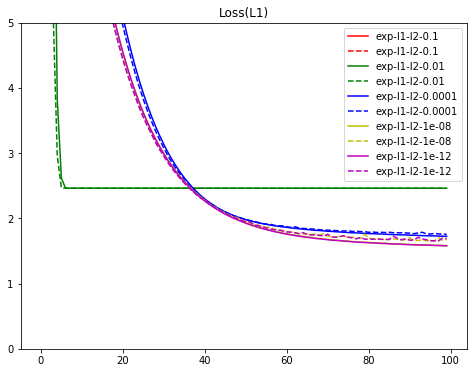

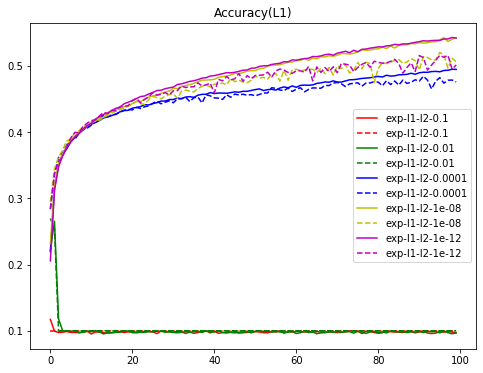

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss(L1)")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy(L1)")
plt.legend()
plt.show()